### Import Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
pd.set_option('display.max_rows', 500)

### Load Database

In [2]:
data = pd.DataFrame({
    "Name":['C1', 'C2', 'C3', 'NC4', 'NC5', 'C6', 'C7+'],
    "Crit Pres (Psia)":[666.40, 706.50, 616.00, 527.90, 488.60, 453.00, 286],
    "Crit Temp (R)":[343.33, 549.92, 666.06, 765.62, 845.80, 923.00, 728+460],
    "Acentric Factor":[0.01, 0.10, 0.15, 0.19, 0.23, 0.25, 0.5733],
    "Mol Weight":[16.043, 30.07, 44.097, 58.123, 72.15, 84, 260]
})

### Define Initial Components

In [3]:
name = ['C1', 'C2', 'C3', 'NC4', 'NC5', 'C6', 'C7+']
comp = [0.780, 0.065, 0.052, 0.039, 0.026, 0.013, 0.025]
print(sum(comp))

1.0


### Get Properties From Database

In [4]:
mw = []
pc = []
tc = []
om = []
for i in range (len(name)):
    mw.append(data[data['Name'] == name[i]]['Mol Weight'].values[0])
    pc.append(data[data['Name'] == name[i]]['Crit Pres (Psia)'].values[0])
    tc.append(data[data['Name'] == name[i]]['Crit Temp (R)'].values[0])
    om.append(data[data['Name'] == name[i]]['Acentric Factor'].values[0])

### Define Pressure and Temperature

In [5]:
pres = [i for i in range (100, 1320, 10)]
temp = 131.3 + 460
r = 10.732

### Calculate Z-Factor By PR EOS

In [6]:
kappa = [0.37464 + 1.54226*i - 0.26992*(i**2) for i in om]
alpha = [(1+kappa[i]*(1-np.sqrt(temp/tc[i])))**2 for i in range (len(kappa))]
ac = [0.45724*((r*tc[i])**2)/pc[i] for i in range (len(name))]
b = [0.07780*r*tc[i]/pc[i] for i in range (len(name))]
aap_mix = 0
b_mix = 0
for i in range (len(name)):
    for j in range (len(name)):
        aap_mix += comp[i]*comp[j]*np.sqrt(ac[i]*ac[j]*alpha[i]*alpha[j])
    b_mix += comp[i]*b[i]
z_fact = []
for p in pres:
    a_val = aap_mix*p/((r*temp)**2)
    b_val = b_mix*p/(r*temp)
    coef = [1, -1+b_val, (a_val-3*(b_val**2) - 2*b_val), - (a_val*b_val - b_val**2 - b_val**3)]
    roots = np.roots(coef)
    z_fact.append(np.max(roots.real))

In [7]:
mw_mix = 0
for i in range (len(name)):
    mw_mix += comp[i]*mw[i]
sg = mw_mix/28.97
pc_mix = 709.604 - 58.718*sg
tc_mix = 170.491 + 307.344*sg

### Calculations of Other Properties

In [8]:
bgi = [0.0283*z_fact[i]*temp/pres[i] for i in range (len(pres))]
rhog = [2.7*sg*pres[i]/(z_fact[i]*temp) for i in range (len(pres))]
visg = []
for i in range (len(pres)):
    a_const = (9.379+0.01607*mw_mix)*(temp**1.5)/(209.2+19.26*mw_mix+temp)
    b_const = 3.448 + 986.4/temp + 0.01009*mw_mix
    c_const = 2.447 - 0.2224*b_const
    visg.append(a_const*np.exp(b_const*((rhog[i]/62.428)**c_const))/1e4)

### Calculation of Pseudo-Pressure

In [9]:
pseudo_pressure = pd.DataFrame({
    "A":pres,
    "B":z_fact,
    "C":visg
})

In [10]:
pseudo_pressure['D'] = 2*pseudo_pressure['A']/(pseudo_pressure['B']*pseudo_pressure['C'])
E = []
for i in range (len(pseudo_pressure['D'].values)):
    if (i==0):
        E.append((pseudo_pressure['D'].values[i])/2)
    else:
        E.append((pseudo_pressure['D'].values[i] + pseudo_pressure['D'].values[i-1])/2)        
pseudo_pressure['E'] = E
F = []
for i in range (len(pseudo_pressure['A'].values)):
    if (i==0):
        F.append(pseudo_pressure['A'].values[i])
    else:
        F.append(pseudo_pressure['A'].values[i] - pseudo_pressure['A'].values[i-1])        
pseudo_pressure['F'] = F
pseudo_pressure['G'] = pseudo_pressure['E']*pseudo_pressure['F']
H = []
for i in range (len(pseudo_pressure['G'].values)):
    if (i==0):
        H.append(pseudo_pressure['G'].values[i])
    else:
        H.append(pseudo_pressure['G'].values[i] + H[i-1])
pseudo_pressure['H'] = H

In [11]:
pseudo_pressure

,A,B,C,D,E,F,G,H
0,100,0.970152,0.010609,19431.592362,9715.796181,100,9.715796e+05,9.715796e+05
1,110,0.967166,0.010626,21407.117304,20419.354833,10,2.041935e+05,1.175773e+06
2,120,0.964181,0.010643,23387.712731,22397.415018,10,2.239742e+05,1.399747e+06
3,130,0.961195,0.010661,25373.213639,24380.463185,10,2.438046e+05,1.643552e+06
4,140,0.958210,0.010679,27363.459643,26368.336641,10,2.636834e+05,1.907235e+06
5,150,0.955225,0.010698,29358.293947,28360.876795,10,2.836088e+05,2.190844e+06
6,160,0.952240,0.010717,31357.562497,30357.928222,10,3.035793e+05,2.494423e+06
7,170,0.949256,0.010736,33361.113288,32359.337892,10,3.235934e+05,2.818017e+06
8,180,0.946272,0.010756,35368.795777,34364.954533,10,3.436495e+05,3.161666e+06
9,190,0.943288,0.010777,37380.460390,36374.628084,10,3.637463e+05,3.525413e+06


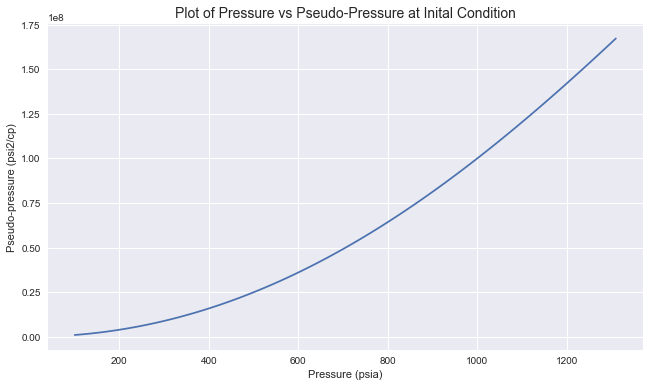

In [12]:
plt.figure(figsize=(16/1.5,9/1.5))
plt.plot(pseudo_pressure['A'], pseudo_pressure['H'])
plt.xlabel("Pressure (psia)")
plt.ylabel("Pseudo-pressure (psi2/cp)")
plt.title("Plot of Pressure vs Pseudo-Pressure at Inital Condition", fontsize=14)
plt.show()

### Define Current Components

In [13]:
name = ['C1', 'C2', 'C3', 'NC4', 'NC5', 'C6', 'C7+']
comp = [0.58, 0.045, 0.042, 0.029, 0.066, 0.063, 0.175]
print(sum(comp))

1.0


### Get Properties From Database

In [14]:
mw = []
pc = []
tc = []
om = []
for i in range (len(name)):
    mw.append(data[data['Name'] == name[i]]['Mol Weight'].values[0])
    pc.append(data[data['Name'] == name[i]]['Crit Pres (Psia)'].values[0])
    tc.append(data[data['Name'] == name[i]]['Crit Temp (R)'].values[0])
    om.append(data[data['Name'] == name[i]]['Acentric Factor'].values[0])

### Define Pressure and Temperature

In [15]:
pres = [i for i in range (100, 1320, 10)]
temp = 131.3 + 460
r = 10.732

### Calculate Z-Factor By PR EOS

In [16]:
kappa = [0.37464 + 1.54226*i - 0.26992*(i**2) for i in om]
alpha = [(1+kappa[i]*(1-np.sqrt(temp/tc[i])))**2 for i in range (len(kappa))]
ac = [0.45724*((r*tc[i])**2)/pc[i] for i in range (len(name))]
b = [0.07780*r*tc[i]/pc[i] for i in range (len(name))]
aap_mix = 0
b_mix = 0
for i in range (len(name)):
    for j in range (len(name)):
        aap_mix += comp[i]*comp[j]*np.sqrt(ac[i]*ac[j]*alpha[i]*alpha[j])
    b_mix += comp[i]*b[i]
z_fact = []
for p in pres:
    a_val = aap_mix*p/((r*temp)**2)
    b_val = b_mix*p/(r*temp)
    coef = [1, -1+b_val, (a_val-3*(b_val**2) - 2*b_val), - (a_val*b_val - b_val**2 - b_val**3)]
    roots = np.roots(coef)
    z_fact.append(np.max(roots.real))

In [17]:
mw_mix = 0
for i in range (len(name)):
    mw_mix += comp[i]*mw[i]
sg = mw_mix/28.97
pc_mix = 709.604 - 58.718*sg
tc_mix = 170.491 + 307.344*sg

### Calculations of Other Properties

In [18]:
bgi = [0.0283*z_fact[i]*temp/pres[i] for i in range (len(pres))]
rhog = [2.7*sg*pres[i]/(z_fact[i]*temp) for i in range (len(pres))]
visg = []
for i in range (len(pres)):
    a_const = (9.379+0.01607*mw_mix)*(temp**1.5)/(209.2+19.26*mw_mix+temp)
    b_const = 3.448 + 986.4/temp + 0.01009*mw_mix
    c_const = 2.447 - 0.2224*b_const
    visg.append(a_const*np.exp(b_const*((rhog[i]/62.428)**c_const))/1e4)

### Calculation of Pseudo-Pressure

In [19]:
pseudo_pressure = pd.DataFrame({
    "A":pres,
    "B":z_fact,
    "C":visg
})

In [20]:
pseudo_pressure['D'] = 2*pseudo_pressure['A']/(pseudo_pressure['B']*pseudo_pressure['C'])
E = []
for i in range (len(pseudo_pressure['D'].values)):
    if (i==0):
        E.append((pseudo_pressure['D'].values[i])/2)
    else:
        E.append((pseudo_pressure['D'].values[i] + pseudo_pressure['D'].values[i-1])/2)        
pseudo_pressure['E'] = E
F = []
for i in range (len(pseudo_pressure['A'].values)):
    if (i==0):
        F.append(pseudo_pressure['A'].values[i])
    else:
        F.append(pseudo_pressure['A'].values[i] - pseudo_pressure['A'].values[i-1])        
pseudo_pressure['F'] = F
pseudo_pressure['G'] = pseudo_pressure['E']*pseudo_pressure['F']
H = []
for i in range (len(pseudo_pressure['G'].values)):
    if (i==0):
        H.append(pseudo_pressure['G'].values[i])
    else:
        H.append(pseudo_pressure['G'].values[i] + H[i-1])
pseudo_pressure['H'] = H

In [21]:
pseudo_pressure

,A,B,C,D,E,F,G,H
0,100,0.870157,0.007515,30586.601119,15293.300559,100,1.529330e+06,1.529330e+06
1,110,0.855593,0.007582,33912.576731,32249.588925,10,3.224959e+05,1.851826e+06
2,120,0.840633,0.007654,37298.786803,35605.681767,10,3.560568e+05,2.207883e+06
3,130,0.825237,0.007732,40750.162877,39024.474840,10,3.902447e+05,2.598128e+06
4,140,0.809354,0.007814,44272.642328,42511.402602,10,4.251140e+05,3.023242e+06
5,150,0.792924,0.007903,47873.446065,46073.044196,10,4.607304e+05,3.483972e+06
6,160,0.775875,0.007999,51561.470071,49717.458068,10,4.971746e+05,3.981147e+06
7,170,0.758114,0.008103,55347.851544,53454.660807,10,5.345466e+05,4.515693e+06
8,180,0.739527,0.008216,59246.813618,57297.332581,10,5.729733e+05,5.088666e+06
9,190,0.719961,0.008341,63276.975408,61261.894513,10,6.126189e+05,5.701285e+06


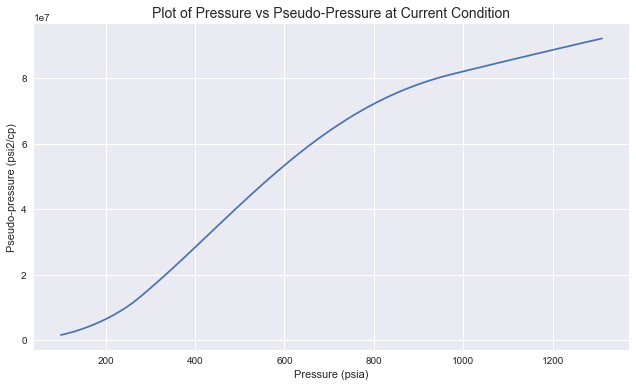

In [22]:
plt.figure(figsize=(16/1.5,9/1.5))
plt.plot(pseudo_pressure['A'], pseudo_pressure['H'])
plt.xlabel("Pressure (psia)")
plt.ylabel("Pseudo-pressure (psi2/cp)")
plt.title("Plot of Pressure vs Pseudo-Pressure at Current Condition", fontsize=14)
plt.show()